## Imports

In [2]:
import os
import sunpy.map
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from typing import Tuple, Dict
from skimage.transform import resize  # Importar resize de scikit-
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

##  Ruta a las IMG

In [3]:
# Ruta base a tus imágenes
data= "/home/alyonaivanova/personal/SOLAR/data/multichannel_SDO_AIA/"
print(f"Files in directory: {os.listdir(data)}")

Files in directory: ['171.0Å', '131.0Å', '211.0Å', '1700.0Å', '304.0Å', '4500.0Å', '335.0Å', '1600.0Å', '193.0Å']


In [4]:
channel_properties = {
    "131.0Å": {"cmap": "Blues", "description": "10 million K (Flare Plasma)"},
    "171.0Å": {"cmap": "YlGnBu", "description": "1 million K (Quiet Corona)"},
    "193.0Å": {"cmap": "Oranges", "description": "1.25 million K (Active Corona)"},
    "211.0Å": {"cmap": "Reds", "description": "2 million K (Hot Corona)"},
    "304.0Å": {"cmap": "PuRd", "description": "50,000 K (Chromosphere/Transition Region)"},
    "335.0Å": {"cmap": "Purples", "description": "2.5 million K (Active Region Corona)"},
    "1600.0Å": {"cmap": "pink", "description": "6,000 K (Transition Region)"},
    "1700.0Å": {"cmap": "Greys", "description": "5,000 K (Photosphere)"},
    "4500.0Å": {"cmap": "coolwarm", "description": "6,000 K (Photosphere Continuum)"}
}
channels = list(channel_properties.keys())

In [5]:
def load_fits_data(channel_dir: str) -> Tuple[np.ndarray, dict]:
    """
    Load FITS data and metadata from the specified channel directory.

    Args:
        channel_dir (str): Directory containing the FITS files.

    Returns:
        Tuple[np.ndarray, dict]: A tuple containing the image data and metadata.
    """
    fits_files = [f for f in os.listdir(channel_dir) if f.endswith(".fits")]
    if not fits_files:
        raise FileNotFoundError(f"No FITS files found in directory: {channel_dir}")
    
    fits_path = os.path.join(channel_dir, fits_files[0])
    aia_map = sunpy.map.Map(fits_path)
    return aia_map.data, aia_map.meta


##  **Creacion de la Mascara**

Observamos que los pixeles afuera del disco solar solo generaran ruido, entonces para
solucionar est voamos a implementar una máscara circular para eliminar los píxeles que no pertenecen
al disco solar. Usaremos la tabla de metadatos para determinar el radio del Sol en 
píxeles y crear la máscara.


### Pasos
1. **Calcular el radio del Sol en píxeles**:
   - Usamos el metadato `R_SUN` y la escala en píxeles (`CDELT1` o `CDELT2`).
2. **Crear la máscara circular**:
   - Usaremos la ecuación del círculo:
     \[
     (x - x_{\text{centro}})^2 + (y - y_{\text{centro}})^2 < R^2
     \]
3. **Aplicar la máscara**:
   - Establecemos los píxeles fuera del círculo como `NaN` o `0`.

In [6]:
def create_circular_mask(data, metadata):
    """
    Crea una máscara circular adaptada al disco solar en los datos.
    """
    ny, nx = data.shape
    x_center = nx // 2
    y_center = ny // 2
    
    # Determinar el radio del Sol en píxeles usando cdelt1 y cdelt2
    cdelt1 = metadata.get("cdelt1", 1.0)  # Arcsec/píxel en X
    solar_radius_arcsec = metadata.get("rsun_obs", 960.0)  # Radio solar en arcsec
    solar_radius_pixels = int(solar_radius_arcsec / abs(cdelt1))  
    # Usamos abs() por si cdelt1 es negativo

    print(f"Metadata for channel: CDELT1={cdelt1}, RSUN_OBS={solar_radius_arcsec}")
    print(f"Solar radius in pixels: {solar_radius_pixels}")

    # Crear las coordenadas de la malla
    y, x = np.ogrid[:ny, :nx]
    distance_from_center = np.sqrt((x - x_center)**2 + (y - y_center)**2)

    # Crear la máscara
    mask = distance_from_center <= solar_radius_pixels
    return mask

In [7]:
def preprocess_image(data: np.ndarray, mask: np.ndarray, size: int = 512) -> np.ndarray:
    """
    Resize the image to the specified size and apply the circular mask.

    Args:
        data (np.ndarray): Original solar image data.
        mask (np.ndarray): Circular mask array.
        size (int): Desired size for resizing the image (default: 512).

    Returns:
        np.ndarray: Masked and resized image data.
    """
    # Redimensionar los datos usando interpolación
    resized_data = resize(data, (size, size), mode="reflect", anti_aliasing=True)
    
    # Redimensionar la máscara sin anti_aliasing (ya que es booleana)
    resized_mask = resize(mask, (size, size), mode="reflect", anti_aliasing=False) > 0.5  
    # Binarizar la máscara

    # Aplicar la máscara a los datos redimensionados
    masked_data = resized_data.copy()
    masked_data[~resized_mask] = np.nan  # Enmascarar píxeles fuera del disco solar

    return masked_data

Channel: 131.0Å, Data Stats: min=-8.0,               max=546.0
Metadata for channel: CDELT1=0.600698, RSUN_OBS=950.956744
Solar radius in pixels: 1583
Channel: 171.0Å, Data Stats: min=-8.0,               max=2606.0
Metadata for channel: CDELT1=0.599489, RSUN_OBS=950.956708
Solar radius in pixels: 1586
Channel: 193.0Å, Data Stats: min=-8.0,               max=3685.0
Metadata for channel: CDELT1=0.600714, RSUN_OBS=950.956396
Solar radius in pixels: 1583
Channel: 211.0Å, Data Stats: min=-8.0,               max=1832.0
Metadata for channel: CDELT1=0.600758, RSUN_OBS=950.956121
Solar radius in pixels: 1582
Channel: 304.0Å, Data Stats: min=-8.0,               max=224.0
Metadata for channel: CDELT1=0.600165, RSUN_OBS=950.956768
Solar radius in pixels: 1584
Channel: 335.0Å, Data Stats: min=-8.0,               max=982.0
Metadata for channel: CDELT1=0.600737, RSUN_OBS=950.956839
Solar radius in pixels: 1582
Channel: 1600.0Å, Data Stats: min=-8.0,               max=7956.0
Metadata for channel: CDEL

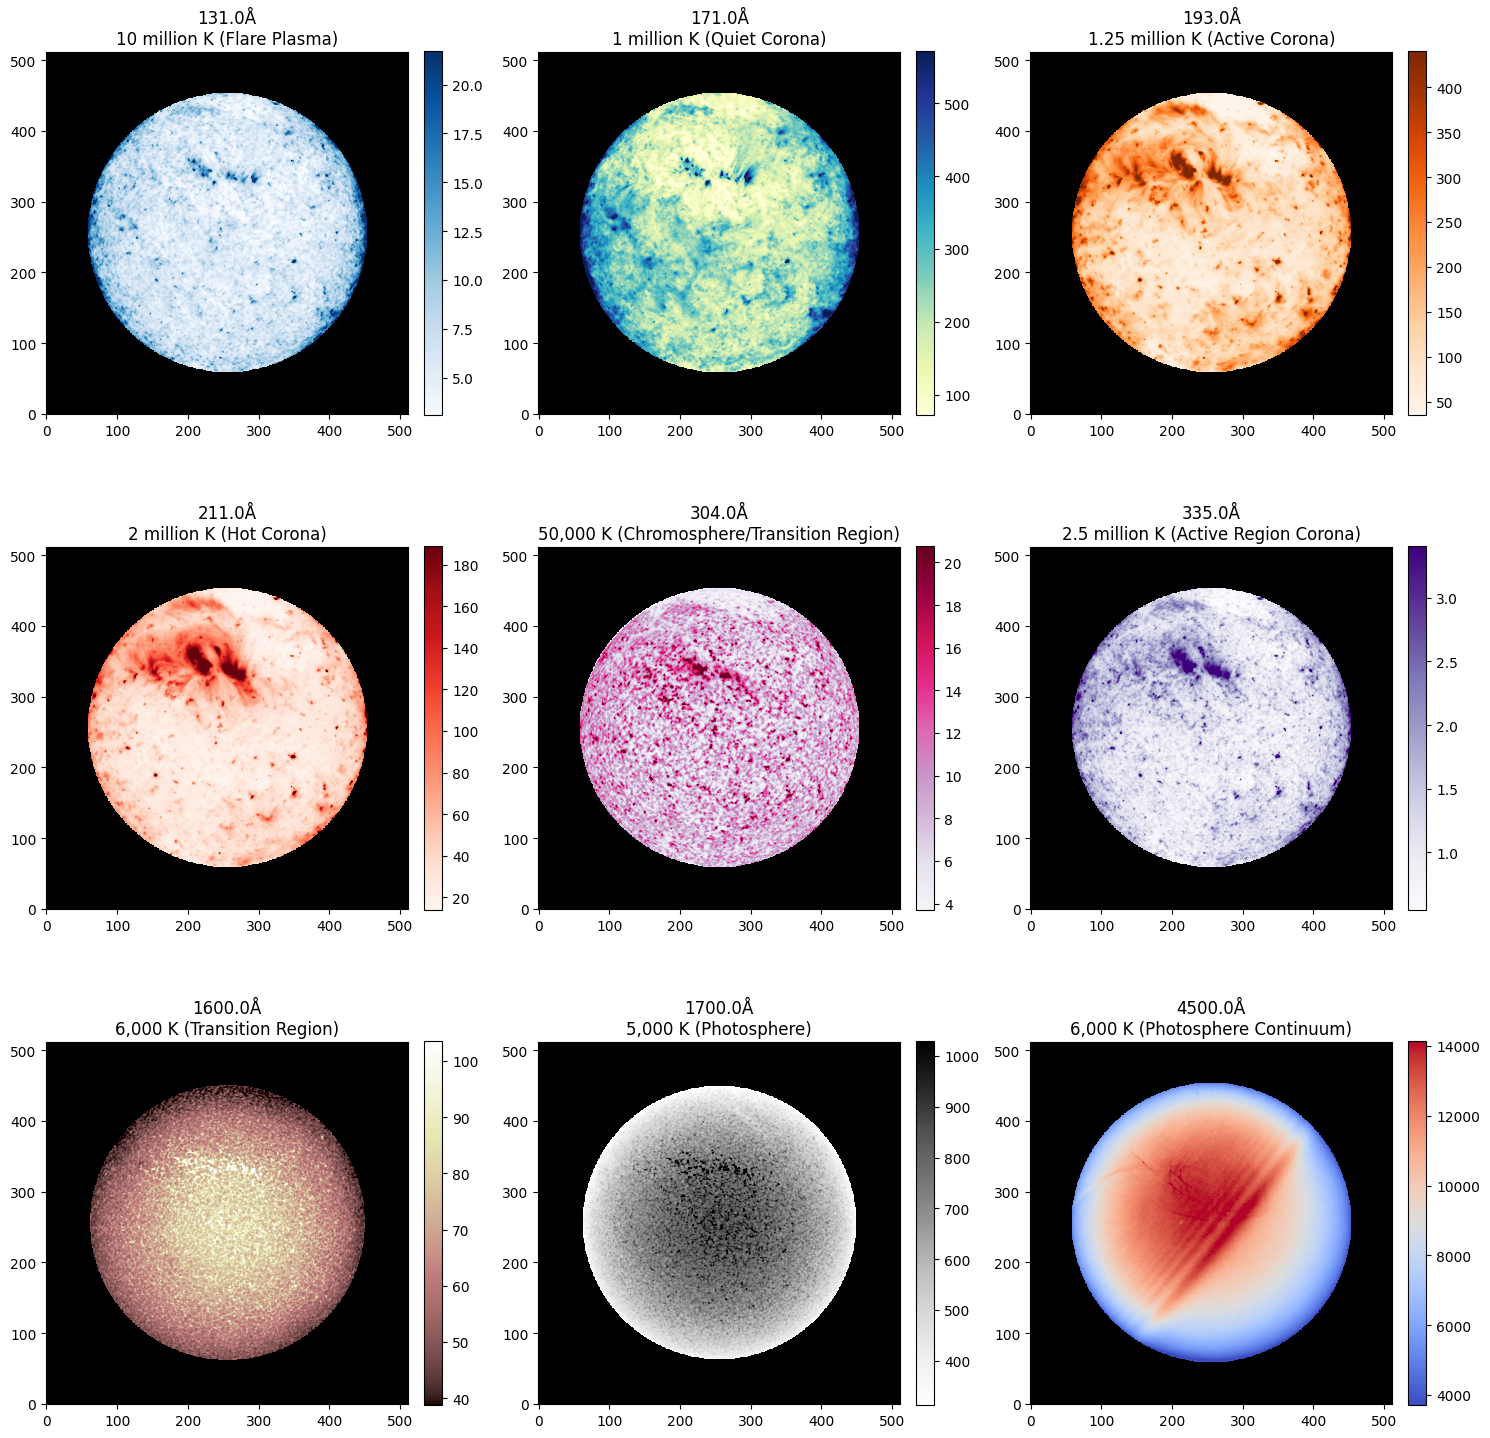

In [8]:
def plot_channel(ax: plt.Axes, channel: str,
                 masked_data: np.ndarray, 
                 channel_properties: dict):
    """
    Plot the processed channel data.

    Args:
        ax (plt.Axes): Matplotlib axis for plotting.
        channel (str): Name of the solar channel.
        masked_data (np.ndarray): Processed and masked image data.
        channel_properties (dict): Properties for each channel (e.g., colormap, description).
    """
    vmin, vmax = np.nanpercentile(masked_data, [1, 99])
    props = channel_properties.get(channel, {"cmap": "gray", "description": "Unknown"})
    ax.set_facecolor("black")
    im = ax.imshow(masked_data, origin="lower", cmap=props["cmap"], vmin=vmin, vmax=vmax)
    ax.set_title(f"{channel}\n{props['description']}", color="Black")
    plt.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)

# Crear figura para mostrar los canales
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()
fig.patch.set_facecolor("white")

# Procesar cada canal
for i, channel in enumerate(channel_properties.keys()):
    channel_dir = os.path.join(data, channel)
    try:
        # Cargar datos y metadatos
        channel_data, metadata = load_fits_data(channel_dir)
        print(f"Channel: {channel}, Data Stats: min={np.nanmin(channel_data)}, \
              max={np.nanmax(channel_data)}")
        
        # Crear máscara circular
        mask = create_circular_mask(channel_data, metadata)

        # Preprocesar la imagen
        masked_data = preprocess_image(channel_data, mask)
        # Verificar si los datos no están completamente enmascarados
        if np.isnan(masked_data).all():
            print(f"Channel {channel}: All data masked.")
            axes[i].set_title(f"{channel} (All Data Masked)", color="Black")
            axes[i].axis("off")
            continue

        # Graficar el canal
        plot_channel(axes[i], channel, masked_data, channel_properties)
    except (FileNotFoundError, ValueError) as e:
        print(f"Error processing channel {channel}: {e}")
        axes[i].set_title(f"{channel} (Error)", color="Blacck")
        axes[i].axis("off")

# Ajustar el diseño
plt.tight_layout()
plt.show()

Primero, necesitamos aplanar las imágenes enmascaradas para obtener un conjunto de datos de píxeles. También normalizaremos los datos para que estén en un rango adecuado para los métodos de detección de anomalías.
### 1. **Normalización Min-Max**
   - **Fórmula**: 
     \[
     X_{\text{normalized}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
     \]
   - **Características**:
     - Escala los datos a un rango específico, generalmente `[0, 1]`.
     - Es útil cuando los datos tienen una distribución uniforme o cuando necesitas que todos los valores estén en un rango específico.
     - **No es robusto a valores atípicos**: Si hay valores extremos (outliers), estos pueden afectar significativamente el valor mínimo y máximo, distorsionando la normalización.

   - **Adecuación para tus datos**:
     - Si los datos en cada canal tienen una distribución uniforme y no hay valores atípicos significativos, **Min-Max** es una buena opción.
     - Sin embargo, en imágenes solares, es común encontrar píxeles con valores extremos (por ejemplo, regiones muy brillantes o muy oscuras), lo que puede hacer que **Min-Max** no sea la mejor opción.

---

### 2. **Normalización Z-score**
   - **Fórmula**:
     \[
     X_{\text{normalized}} = \frac{X - \mu}{\sigma}
     \]
     Donde \(\mu\) es la media y \(\sigma\) es la desviación estándar.
   - **Características**:
     - Transforma los datos para que tengan una media de `0` y una desviación estándar de `1`.
     - Es útil cuando los datos tienen una distribución normal o aproximadamente normal.
     - **Es más robusto a valores atípicos** que **Min-Max**, pero aún puede verse afectado por outliers extremos, ya que la media y la desviación estándar son sensibles a estos.

   - **Adecuación para tus datos**:
     - Si los datos en cada canal tienen una distribución normal o no tienen valores atípicos extremos, **Z-score** es una buena opción.
     - Sin embargo, en imágenes solares, es posible que algunos canales tengan distribuciones no normales o valores atípicos, lo que podría limitar la efectividad de **Z-score**.

---

### 3. **Escalado robusto (Recomendado para tus datos)**
   - Aunque no lo mencionaste explícitamente, el **escalado robusto** es una excelente opción para datos con valores atípicos.
   - **Fórmula**:
     \[
     X_{\text{scaled}} = \frac{X - \text{mediana}}{\text{IQR}}
     \]
     Donde IQR es el rango intercuartílico (diferencia entre el percentil 75 y el percentil 25).
   - **Características**:
     - Utiliza la mediana y el IQR, que son robustos a valores atípicos.
     - Es ideal cuando los datos tienen distribuciones no normales o cuando hay valores extremos.
   - **Adecuación para tus datos**:
     - Dado que las imágenes solares pueden tener valores atípicos (por ejemplo, regiones muy brillantes o muy oscuras), el **escalado robusto** es probablemente la mejor opción para normalizar tus datos.

---

### Conclusión: ¿Cuál método es más adecuado?

1. **Si los datos no tienen valores atípicos significativos**:
   - Usa **Min-Max** si los datos tienen una distribución uniforme.
   - Usa **Z-score** si los datos tienen una distribución normal.

2. **Si los datos tienen valores atípicos o distribuciones no normales**:
   - Usa **escalado robusto**. Este es el método más recomendado para tus imágenes solares, ya que es robusto a valores atípicos y funciona bien con distribuciones no normales.



In [9]:
def prepare_data(masked_data):
    """
    Prepara los datos para la detección de anomalías.

    Args:
        masked_data (np.ndarray): Imagen enmascarada (2D).

    Returns:
        np.ndarray: Datos aplanados y normalizados.
    """
    # Aplanar la imagen enmascarada
    flattened_data = masked_data[~np.isnan(masked_data)].reshape(-1, 1)  
    # Eliminar NaN y aplanar
    
    # Escalado robusto
    scaler = RobustScaler() 
    flattened_data_normalized = scaler.fit_transform(flattened_data)
    
    return flattened_data_normalized

##  Isolation Forest.

In [10]:

def detect_anomalies_isolation_forest(
    data: np.ndarray,
    contamination: float = 0.05) -> np.ndarray:
    """
    Detecta anomalías usando Isolation Forest.

    Args:
        data (np.ndarray): Datos aplanados y normalizados.
        contamination (float): Proporción esperada de anomalías (default: 0.05).

    Returns:
        np.ndarray: Etiquetas de anomalías (1 para normales, -1 para anomalías).
    """
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    anomalies = iso_forest.fit_predict(data)
    return anomalies
# Paso 1: Preparar los  usammos la funcion anterior
flattened_data_normalized = prepare_data(masked_data)

# Paso 2: Detectar anomalías con el modelo
anomalies = detect_anomalies_isolation_forest(flattened_data_normalized)


Visualizar las Anomalías

Metadata for channel: CDELT1=0.600737, RSUN_OBS=950.956839
Solar radius in pixels: 1582


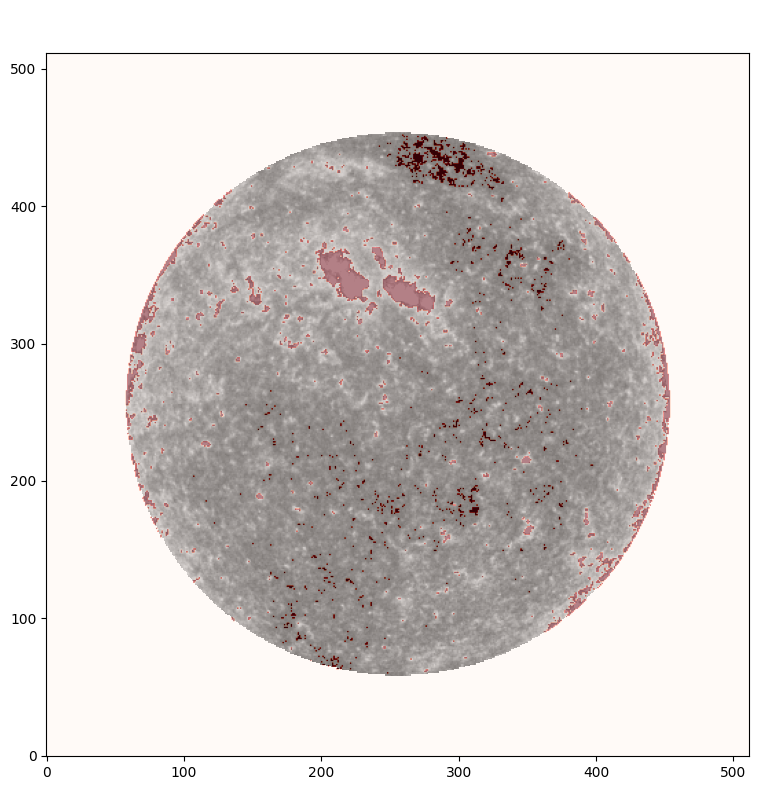

In [11]:
def plot_anomalies(ax, masked_data: np.ndarray, anomalies: np.ndarray, method_name: str):
    """
    Grafica las anomalías detectadas en la imagen.

    Args:
        ax (plt.Axes): Eje para graficar.
        masked_data (np.ndarray): Imagen enmascarada.
        anomalies (np.ndarray): Etiquetas de anomalías (1 para normales, -1 para anomalías).
        method_name (str): Nombre del método usado.
    """
    # Crear una máscara de anomalías
    anomaly_mask = np.zeros_like(masked_data, dtype=bool)
    anomaly_mask[~np.isnan(masked_data)] = anomalies == -1  # Mapear -1 a True (anomalías)
    
    # Graficar la imagen original
    ax.imshow(masked_data, origin="lower", cmap="gray", vmin=np.nanpercentile(masked_data, 1), vmax=np.nanpercentile(masked_data, 99))
    
    # Superponer las anomalías
    ax.imshow(anomaly_mask, origin="lower", cmap="Reds", alpha=0.5)
    
    # Añadir título
    ax.set_title(f"{method_name}\nAnomalías Detectadas", color="white")

# Especificar el canal que deseas procesar
channel = "335.0Å"

try:
    # Construir la ruta del directorio del canal
    channel_dir = os.path.join(data, channel)
    
    # Cargar datos y metadatos del canal 335.0Å
    channel_data, metadata = load_fits_data(channel_dir)
    
    # Crear máscara circular
    mask = create_circular_mask(channel_data, metadata)
    
    # Preprocesar la imagen (aplicar máscara)
    masked_data = preprocess_image(channel_data, mask)
    
    # Preparar los datos para la detección de anomalías
    flattened_data_normalized = prepare_data(masked_data)
    
    # Detectar anomalías usando Isolation Forest
    anomalies = detect_anomalies_isolation_forest(flattened_data_normalized)
    
    # Visualizar las anomalías
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_anomalies(ax, masked_data, anomalies, "Isolation Forest")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error processing channel {channel}: {e}")

Metadata for channel: CDELT1=0.600737, RSUN_OBS=950.956839
Solar radius in pixels: 1582


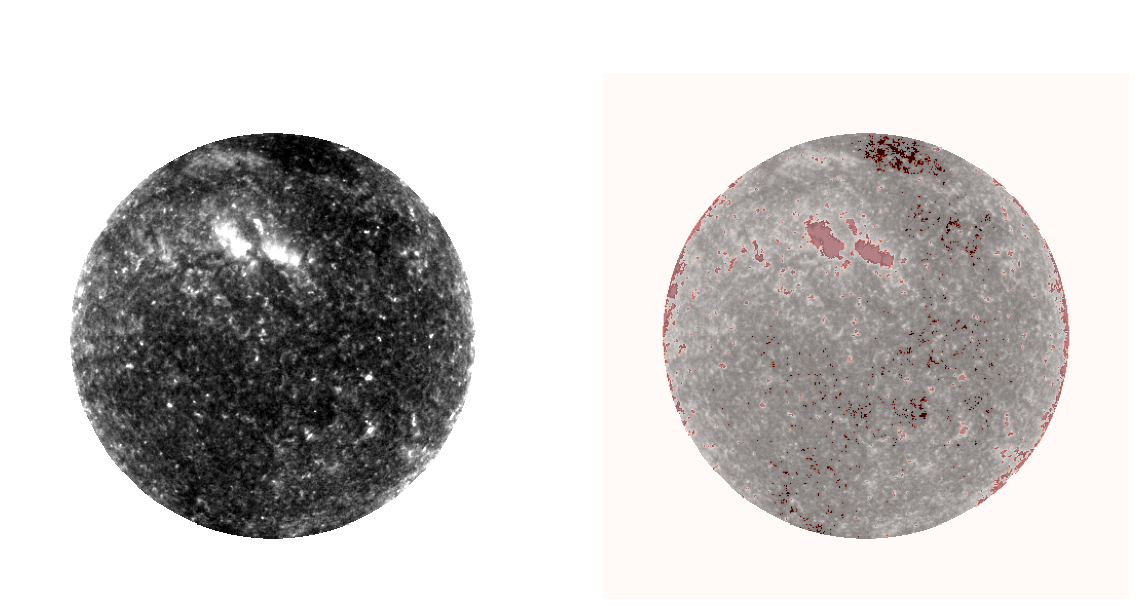

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_anomalies(ax, masked_data: np.ndarray, anomalies: np.ndarray, method_name: str, channel: str):
    """
    Grafica las anomalías detectadas en la imagen.

    Args:
        ax (plt.Axes): Eje para graficar.
        masked_data (np.ndarray): Imagen enmascarada.
        anomalies (np.ndarray): Etiquetas de anomalías (1 para normales, 0 para anomalías).
        method_name (str): Nombre del método usado.
        channel (str): Nombre del canal.
    """
    # Crear una máscara de anomalías
    anomaly_mask = np.zeros_like(masked_data, dtype=bool)
    anomaly_mask[~np.isnan(masked_data)] = anomalies == 1  # Mapear 1 a True (anomalías)
    
    # Graficar la imagen original
    ax.imshow(masked_data, origin="lower", cmap="gray", vmin=np.nanpercentile(masked_data, 1), vmax=np.nanpercentile(masked_data, 99))
    
    # Superponer las anomalías
    ax.imshow(anomaly_mask, origin="lower", cmap="Reds", alpha=0.5)
    
    # Añadir título
    ax.set_title(f"{channel}\n{method_name}\nAnomalías Detectadas", color="white")
    ax.axis('off')  # Ocultar ejes

# Especificar el canal que deseas procesar
channel = "335.0Å"

try:
    # Construir la ruta del directorio del canal
    channel_dir = os.path.join(data, channel)
    
    # Cargar datos y metadatos del canal 335.0Å
    channel_data, metadata = load_fits_data(channel_dir)
    
    # Crear máscara circular
    mask = create_circular_mask(channel_data, metadata)
    
    # Preprocesar la imagen (aplicar máscara)
    masked_data = preprocess_image(channel_data, mask)
    
    # Preparar los datos para la detección de anomalías
    flattened_data_normalized = prepare_data(masked_data)
    
    # Detectar anomalías usando Isolation Forest
    anomalies = detect_anomalies_isolation_forest(flattened_data_normalized)
    
    # Convertir las etiquetas de anomalías a 1 (normales) y 0 (anomalías)
    anomalies = np.where(anomalies == 1, 0, 1)
    
    # Crear un mosaico de dos celdas
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 fila, 2 columnas

    # Graficar la imagen original en la primera celda
    ax1.imshow(masked_data, origin="lower", cmap="gray", vmin=np.nanpercentile(masked_data, 1), vmax=np.nanpercentile(masked_data, 99))
    ax1.set_title(f"{channel}\nImagen Original", color="white")
    ax1.axis('off')  # Ocultar ejes

    # Graficar las anomalías en la segunda celda
    plot_anomalies(ax2, masked_data, anomalies, "Isolation Forest", channel)

    # Ajustar el layout y mostrar la figura
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error processing channel {channel}: {e}")

Metadata for channel: CDELT1=0.600698, RSUN_OBS=950.956744
Solar radius in pixels: 1583
Metadata for channel: CDELT1=0.599489, RSUN_OBS=950.956708
Solar radius in pixels: 1586
Metadata for channel: CDELT1=0.600714, RSUN_OBS=950.956396
Solar radius in pixels: 1583
Metadata for channel: CDELT1=0.600758, RSUN_OBS=950.956121
Solar radius in pixels: 1582
Metadata for channel: CDELT1=0.600165, RSUN_OBS=950.956768
Solar radius in pixels: 1584
Metadata for channel: CDELT1=0.600737, RSUN_OBS=950.956839
Solar radius in pixels: 1582
Metadata for channel: CDELT1=0.609373, RSUN_OBS=950.956624
Solar radius in pixels: 1560
Metadata for channel: CDELT1=0.612898, RSUN_OBS=950.956406
Solar radius in pixels: 1551
Metadata for channel: CDELT1=0.599945, RSUN_OBS=950.95678
Solar radius in pixels: 1585


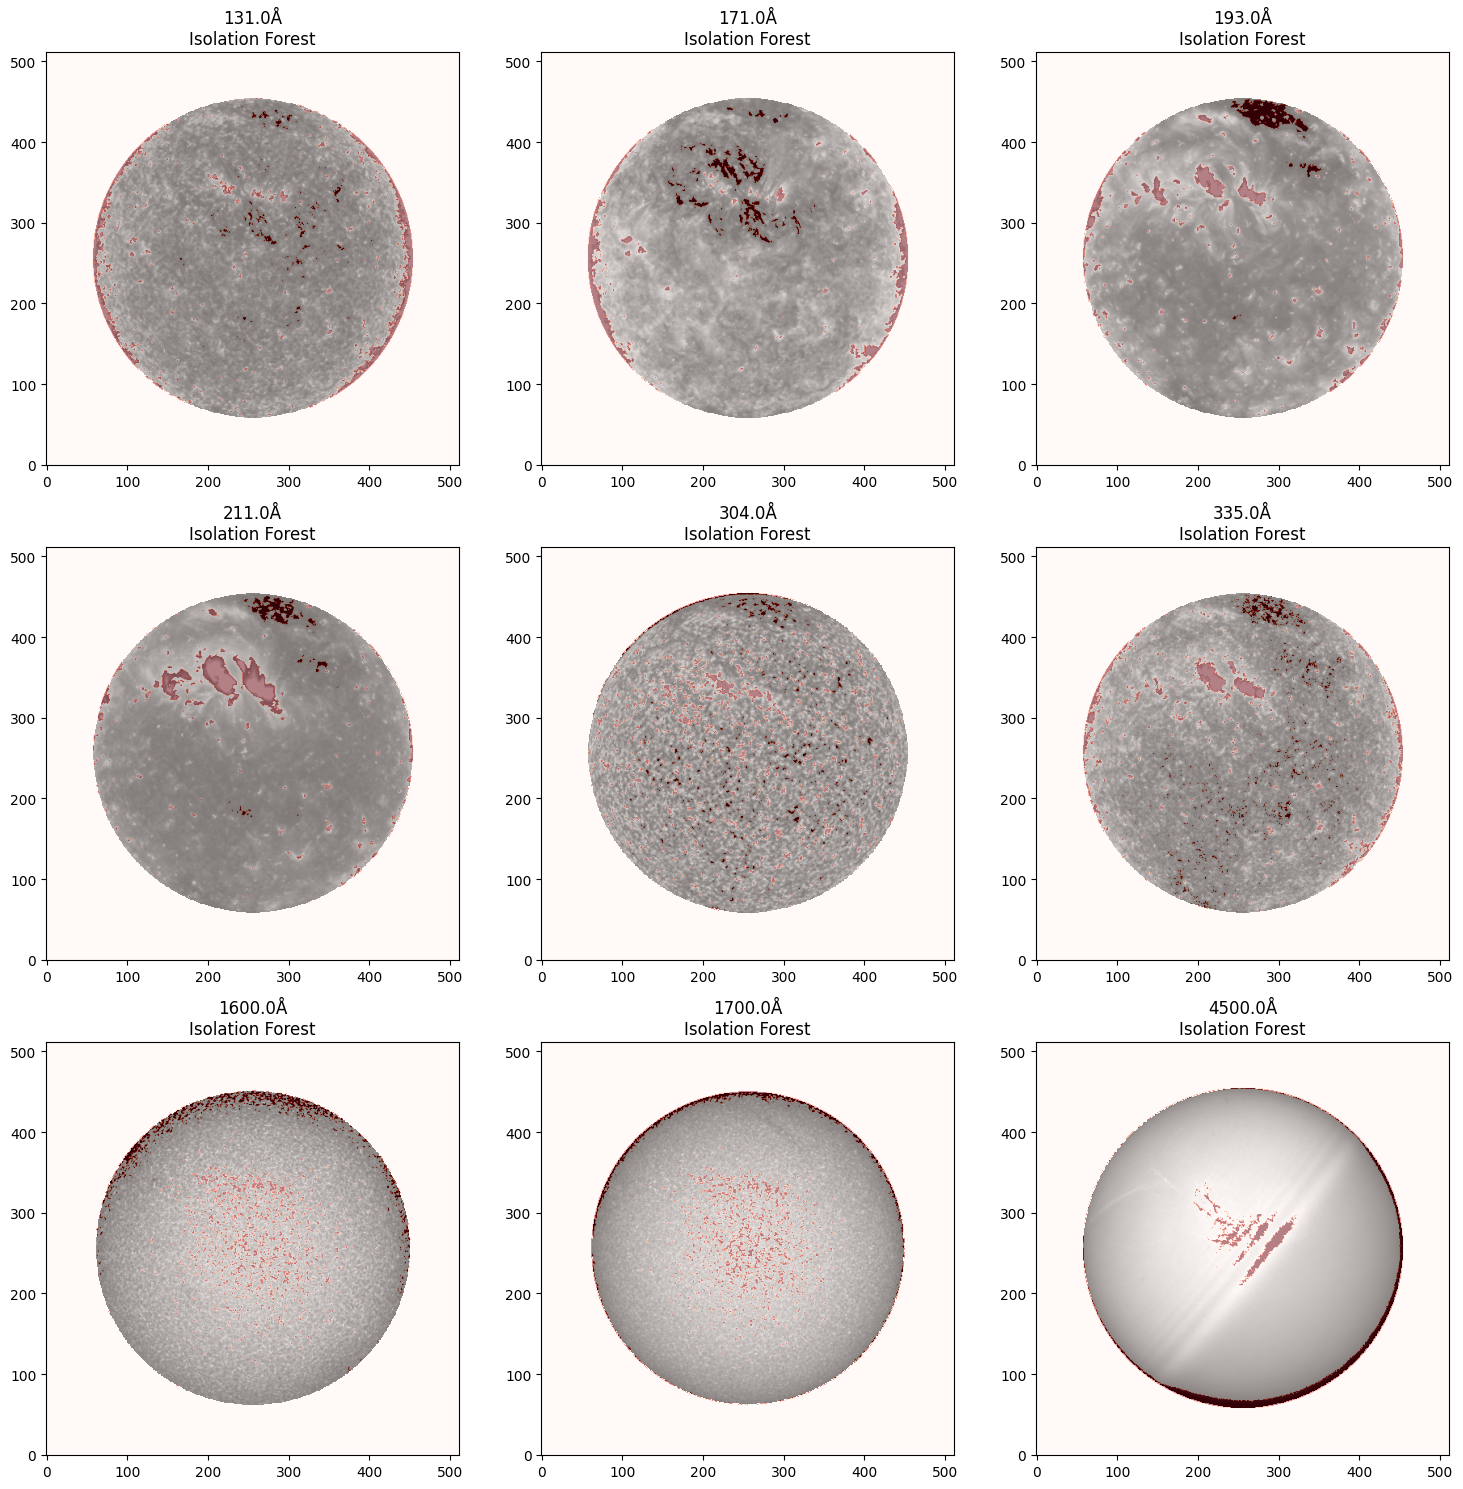

In [13]:
def plot_comparison(ax, masked_data: np.ndarray, anomalies: np.ndarray, channel: str, method_name: str):
    """
    Grafica las anomalías detectadas en la imagen.

    Args:
        ax (plt.Axes): Eje para graficar.
        masked_data (np.ndarray): Imagen enmascarada.
        anomalies (np.ndarray): Etiquetas de anomalías (1 para normales, -1 para anomalías).
        channel (str): Nombre del canal.
        method_name (str): Nombre del método usado.
    """
    # Crear una máscara de anomalías
    anomaly_mask = np.zeros_like(masked_data, dtype=bool)
    anomaly_mask[~np.isnan(masked_data)] = anomalies == -1  # Mapear -1 a True (anomalías)
    
    # Graficar la imagen original
    ax.imshow(masked_data, origin="lower", cmap="gray", vmin=np.nanpercentile(masked_data, 1), vmax=np.nanpercentile(masked_data, 99))
    
    # Superponer las anomalías
    ax.imshow(anomaly_mask, origin="lower", cmap="Reds", alpha=0.5)
    
    # Añadir título
    ax.set_title(f"{channel}\n{method_name}", color="black")
    
# Crear una figura para el mosaico
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3 filas, 3 columnas
axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar el acceso

# Procesar cada canal
for i, channel in enumerate(channels):
    channel_dir = os.path.join(data, channel)
    try:
        # Cargar datos y metadatos
        channel_data, metadata = load_fits_data(channel_dir)
        
        # Crear máscara circular
        mask = create_circular_mask(channel_data, metadata)

        # Preprocesar la imagen
        masked_data = preprocess_image(channel_data, mask)

        # Preparar los datos para la detección de anomalías
        flattened_data_normalized = prepare_data(masked_data)

        # Detectar anomalías usando Isolation Forest
        anomalies = detect_anomalies_isolation_forest(flattened_data_normalized)

        # Graficar la comparación en la celda correspondiente
        plot_comparison(axes[i], masked_data, anomalies, channel, method_name="Isolation Forest")
    except (FileNotFoundError, ValueError) as e:
        print(f"Error processing channel {channel}: {e}")
        axes[i].set_title(f"{channel} (Error)", color="black")
        axes[i].axis("off")

# Ajustar el diseño
plt.tight_layout()
plt.show()


## Iso Forest 2

In [14]:
iso_forest = IsolationForest(n_estimators=500, max_samples=0.8, contamination="auto", random_state=42)

In [ ]:
# Crear una figura para el mosaico
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3 filas, 3 columnas
axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar el acceso

# Procesar cada canal
for i, channel in enumerate(channels):
    channel_dir = os.path.join(data, channel)
    try:
        # Cargar datos y metadatos
        channel_data, metadata = load_fits_data(channel_dir)
        
        # Crear máscara circular
        mask = create_circular_mask(channel_data, metadata)

        # Preprocesar la imagen
        masked_data = preprocess_image(channel_data, mask)

        # Preparar los datos para la detección de anomalías
        flattened_data_normalized = prepare_data(masked_data)

        # Detectar anomalías usando Isolation Forest con hiperparámetros ajustados
        iso_forest = IsolationForest(n_estimators=500, max_samples=0.8, contamination="auto", random_state=42)
        anomalies = iso_forest.fit_predict(flattened_data_normalized)

        # Graficar la comparación en la celda correspondiente
        plot_comparison(axes[i], masked_data, anomalies, channel, method_name="Isolation Forest (Mejorado)")
    except (FileNotFoundError, ValueError) as e:
        print(f"Error processing channel {channel}: {e}")
        axes[i].set_title(f"{channel} (Error)", color="black")
        axes[i].axis("off")

# Ajustar el diseño
plt.tight_layout()
plt.show()


Metadata for channel: CDELT1=0.600698, RSUN_OBS=950.956744
Solar radius in pixels: 1583
Metadata for channel: CDELT1=0.599489, RSUN_OBS=950.956708
Solar radius in pixels: 1586
Metadata for channel: CDELT1=0.600714, RSUN_OBS=950.956396
Solar radius in pixels: 1583
Metadata for channel: CDELT1=0.600758, RSUN_OBS=950.956121
Solar radius in pixels: 1582
Metadata for channel: CDELT1=0.600165, RSUN_OBS=950.956768
Solar radius in pixels: 1584
Metadata for channel: CDELT1=0.600737, RSUN_OBS=950.956839
Solar radius in pixels: 1582
Metadata for channel: CDELT1=0.609373, RSUN_OBS=950.956624
Solar radius in pixels: 1560
Metadata for channel: CDELT1=0.612898, RSUN_OBS=950.956406
Solar radius in pixels: 1551
Metadata for channel: CDELT1=0.599945, RSUN_OBS=950.95678
Solar radius in pixels: 1585


## Busqueda de hiperparametros

In [ ]:
# Definir la métrica de evaluación (F1-score para detección de anomalías)
def anomaly_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label=-1)  # Usar pos_label=-1 para anomalías

scorer = make_scorer(anomaly_f1_score)

param_grid = {
    'n_estimators': [100, 200],  # Reducir el número de opciones
    'max_samples': [0.8, 1.0],   # Proporción de muestras por árbol
    'contamination': [0.05, 0.1],  # Proporción esperada de anomalías
    'max_features': [0.8, 1.0]   # Proporción de características por árbol
}

# Crear el modelo Isolation Forest
iso_forest = IsolationForest(random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=iso_forest,
    param_grid=param_grid,
    scoring=scorer,  # Usar F1-score como métrica
    cv=5,            # Validación cruzada de 5 folds
    n_jobs=-1        # Usar todos los núcleos de la CPU
)

# Supongamos que ya tienes `masked_data` preparado
# Paso 1: Preparar los datos
flattened_data_normalized = prepare_data(masked_data)

# Ajustar GridSearchCV a los datos (usar etiquetas ficticias para evaluación)
# Nota: En un escenario real, necesitarías etiquetas verdaderas para evaluar el modelo
# Aquí asumimos que todas las muestras son normales (1) para la evaluación
y_true = np.ones(len(flattened_data_normalized))  # Etiquetas ficticias

grid_search.fit(flattened_data_normalized, y_true)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Entrenar el modelo con los mejores hiperparámetros
best_iso_forest = grid_search.best_estimator_

# Paso 2: Detectar anomalías con el modelo optimizado
anomalies = best_iso_forest.fit_predict(flattened_data_normalized)

# Convertir las etiquetas de anomalías a 1 (normales) y 0 (anomalías)
anomalies = np.where(anomalies == 1, 0, 1)

print("Anomalías detectadas:")
print(anomalies)